In [1]:
import numpy as np
import pandas as pd

import os, sys
import random
import sklearn

try:
    os.chdir('CrowdInference')
    sys.path.append(os.getcwd())
except:
    pass

import crowd_inference.methods.dawid_skene as ds
import crowd_inference.methods.majority_vote as mv
import crowd_inference.methods.raykar as r
import crowd_inference.methods.raykar_boosting as rb
import crowd_inference.methods.raykar_plus_ds as rds
import crowd_inference.methods.classifier as cls
import benchmark as bm

from crowd_inference.truth_inference import NoFeaturesInference, TruthInference, WithFeaturesInference
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
from collections import defaultdict
import tests.data_provider as data
from tqdm.auto import tqdm

import seaborn as sns
sns.set()
sns.set(font_scale=1.2)

from importlib import reload

def reload_all():
    reload(ds)
    reload(r)
    reload(rb)
    reload(rds)
    reload(cls)
    reload(bm)

reload(data)

<module 'tests.data_provider' from '/Users/andrey/Documents/5Course/CrowdInference/tests/data_provider.py'>

In [2]:
sentiment_data = data.SentimentDataProvider('./resources/datasets/sentiment_polarity/mturk_answers.csv',
                                       './resources/datasets/sentiment_polarity/polarity_gold_lsa_topics.csv')

Iter 00, logit: -3.010473
Iter 10, logit: -2.779897
[0.50543171 0.49456829]
---------------
Label accuracy is 0.9147829565913183
--------------------------------------------------
Data has 600 features
Iter 00, logit: -2.930729
Iter 10, logit: -2.610976
(4999, 600)
Classifier train accuracy is 0.7091418283656732
(5428, 600)
Classifier test accuracy is 0.6302505526897568
Label accuracy is 0.9159831966393278
--------------------------------------------------
Data has 600 features
Iter 00, logit: -2.899099
Average Raykar weight is 0.706741348269654
Iter 10, logit: -2.496428
Average Raykar weight is 0.7243448689737948


KeyboardInterrupt: 

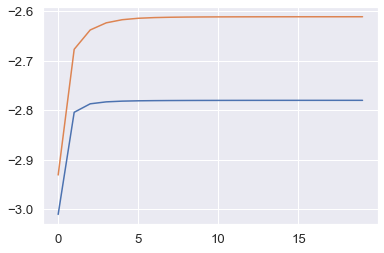

In [4]:
reload_all()
sentiment_methods, sentiment_points, advantages_matrix = bm.compare_methods(sentiment_data, max_iter=15, lr=0.5)
# Classifier test accuracy is 0.6298820928518791

In [ ]:
buckets, confidences, wrong, correct = bm.build_grad_hist(sentiment_data, sentiment_methods, sentiment_points, 'Sentiment', 600)
condidence_sentiment = bm.get_confidence(buckets[0], confidences[0])

In [ ]:
reload_all()
sentiment_methods, sentiment_points, advantages_matrix = bm.compare_methods(sentiment_data, max_iter=15, lr=0.5, 
                                                                            confidence_estimator=condidence_sentiment)

In [ ]:
sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])]

In [ ]:
sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])]

In [ ]:
reload_all()
bm.plot_flips(sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])], 
              sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])], 'conf_mx_ds', 'Sentiment', 'R улучшил', 'R ухудшил')

In [ ]:
reload_all()
bm.plot_flips(sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])], 
              sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])], 'conf_mx_ds', 'Sentiment')

In [ ]:
bm.plots_for_point(sentiment_points, sentiment_data, sentiment_methods, 4624)

In [ ]:
def scatter_cls(pts):
    print(len(pts))
    r = list(map(lambda x: x[0], pts['classifier_r']))
    rds = list(map(lambda x: x[0], pts['classifier_rds']))
    plt.scatter(r, rds)
    
scatter_cls(sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])])

In [ ]:
res = []
for _, row in sentiment_points.iterrows():
    res.append(row.conf_mx_r + np.log(row.classifier_r) + np.log(row.classifier_rds))
res = np.array(res)
res = np.exp(res)
res = sklearn.preprocessing.normalize(res, axis=1, norm='l1')

estimates = {}
for i, row in sentiment_points.iterrows():
    estimates[row['task']] = sentiment_methods[2].values[np.argmax(res[i])]
    
    all_points = 0
accepted = 0

for point in sentiment_data.gold():
    if point.task in estimates:
        estimate = estimates[point.task]
        all_points += 1
        if point.value == estimate:
            accepted += 1

accuracy = accepted / all_points

accuracy

In [ ]:
reload_all()
bm.boosting_classifiers_distr(sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])],
                              sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])], 'Sentiment') 

In [ ]:
reload_all()
bm.plot_all_gradients(sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])],
                              sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])], 'Sentiment') 